# Imports

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ENABLE_CASHING = False

# Loading the data

In [3]:
data = pd.read_csv('train.csv')

# Inspecting the `dataset`

In [4]:
print("Number of null cells")
data.isnull().sum()

Number of null cells


id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [5]:
f"Number of duplicate rows: {data.duplicated().sum()}"

'Number of duplicate rows: 0'

## statistices

<AxesSubplot:>

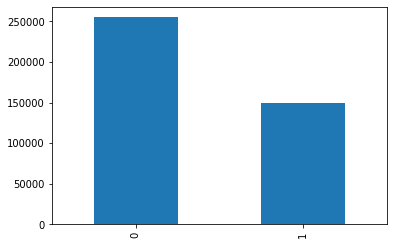

In [6]:
data['is_duplicate'].value_counts().plot(kind='bar')

# Preprocessing

In [7]:
print(f"Number of rows: {len(data)}")
print("Number of null cells")
data.isnull().sum()

Number of rows: 404290
Number of null cells


id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [8]:
data.dropna(inplace=True)

In [9]:
print(f"Number of rows: {len(data)}")
print("Number of null cells")
data.isnull().sum()

Number of rows: 404287
Number of null cells


id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

# Featurn Extraction

* Question character length
* Question word count
* Number of common words between the 2 question
* TF-IDF

## Question character length

In [10]:
def get_que_char_len(data):
    if os.path.exists(r'artifacts/que_char_len.csv') and ENABLE_CASHING:
        que_char_len = pd.read_csv(r'artifacts/que_char_len.csv')
    else:
        que_char_len = pd.DataFrame()
        que_char_len['q1_char_len'] = data['question1'].str.len()
        que_char_len['q2_char_len'] = data['question2'].str.len()
        if ENABLE_CASHING:
            que_char_len.to_csv(r'artifacts/que_char_len.csv', index=False)
    return que_char_len

In [11]:
# get_que_char_len(data).head()

## Question word count

In [12]:
def get_que_word_cnt(data):
    if os.path.exists(r'artifacts/que_word_cnt.csv') and ENABLE_CASHING:
        que_word_cnt = pd.read_csv(r'artifacts/que_word_cnt.csv' )
    else:
        que_word_cnt = pd.DataFrame()
        que_word_cnt['q1_word_cnt'] = data['question1'].apply(lambda row: len(word_tokenize(row)))
        que_word_cnt['q2_word_cnt'] = data['question2'].apply(lambda row: len(word_tokenize(row)))
    if ENABLE_CASHING:
        que_word_cnt.to_csv(r'artifacts/que_word_cnt.csv', index=False)
    return que_word_cnt

In [13]:
# get_que_word_cnt(data).head()

## Number of common words between the 2 question. 

In [14]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), word_tokenize(row['question1'])))
    w2 = set(map(lambda word: word.lower().strip(), word_tokenize(row['question2'])))    
    return len(w1 & w2) # return the len of intersects.

In [15]:
def get_que_com_words(data):
    if os.path.exists(r'artifacts/que_com_words.csv') and ENABLE_CASHING:
        que_com_words = pd.read_csv(r'artifacts/que_com_words.csv')
    else:
        que_com_words = pd.DataFrame()
        que_com_words['que_com_words'] = data.apply(common_words, axis=1)
        if ENABLE_CASHING:
            que_com_words.to_csv(r'artifacts/que_com_words.csv', index=False)
    return que_com_words

In [16]:
# get_que_com_words(data).head()

## TF-IDF

In [17]:
def get_que_tfidf(data):
    if os.path.exists(r'artifacts/que_tfidf.csv') and ENABLE_CASHING:
        que_tfidf = pd.read_csv(r'artifacts/que_tfidf.csv')
    else:
        ques = list(data['question1']) + list(data['question2'])
        tfidf = TfidfVectorizer(lowercase=False, max_features=250)
        q1_tfidf, q2_tfidf = np.vsplit(tfidf.fit_transform(ques).toarray(), 2)
        que1_tfidf = pd.DataFrame(q1_tfidf, index=data.index)
        que2_tfidf = pd.DataFrame(q2_tfidf, index=data.index)
        que_tfidf = pd.concat([que1_tfidf, que2_tfidf], axis=1, copy=False)
        if ENABLE_CASHING:
            que_tfidf.to_csv(r'artifacts/que_tfidf.csv', index=False)
    return que_tfidf

In [18]:
# get_que_tfidf(data).head()

## Concatinating all the features

In [19]:
if not os.path.exists(r'artifacts/') and ENABLE_CASHING:
    os.mkdir(r'artifacts')
if os.path.exists(r'artifacts/total_data.csv') and ENABLE_CASHING:
    total_data = pd.read_csv(r'artifacts/total_data.csv')
else:
    target = data['is_duplicate']
    total_data = pd.concat(
        [
            get_que_char_len(data),
            get_que_word_cnt(data),
            get_que_com_words(data),
            get_que_tfidf(data),
            target
        ],
        axis=1,
        copy=False
    )
    if ENABLE_CASHING:
        total_data.to_csv(r'artifacts/total_data.csv', index=False)

In [20]:
total_data.head()

,q1_char_len,q2_char_len,q1_word_cnt,q2_word_cnt,que_com_words,0,1,2,3,4,...,241,242,243,244,245,246,247,248,249,is_duplicate
0,66,57,15,13,12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
1,51,88,11,16,8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.364143,0.0,0.0,0.0,0.0,0
2,73,59,15,11,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
3,50,65,13,19,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
4,76,39,16,8,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.504030,0.0,0.0,0.0,0.0,0


In [21]:
f"Size in ram: {sys.getsizeof(total_data) >> 20} MB"

'Size in ram: 1563 MB'

# Statistics

In [37]:
import warnings
warnings.filterwarnings('ignore')

## question char len

/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


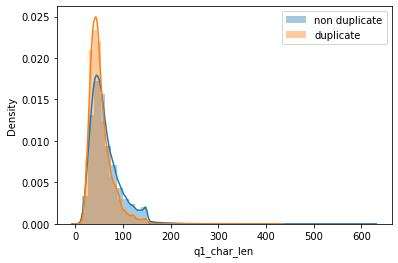

/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


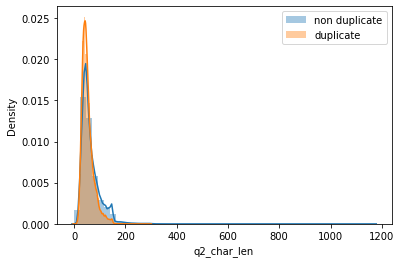

In [31]:
sns.distplot(total_data[total_data['is_duplicate'] == 0]['q1_char_len'],label='non duplicate')
sns.distplot(total_data[total_data['is_duplicate'] == 1]['q1_char_len'],label='duplicate')
plt.legend()
plt.show()
sns.distplot(total_data[total_data['is_duplicate'] == 0]['q2_char_len'],label='non duplicate')
sns.distplot(total_data[total_data['is_duplicate'] == 1]['q2_char_len'],label='duplicate')
plt.legend()
plt.show()

## question word count

/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


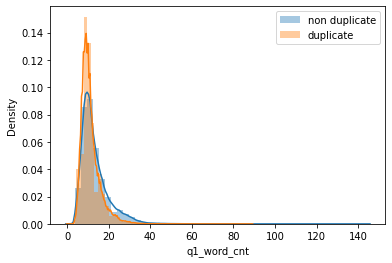

/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


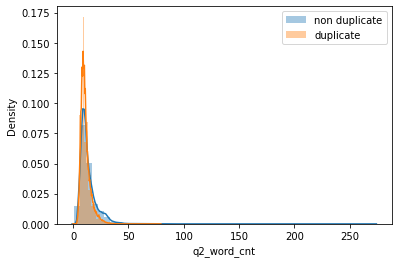

In [32]:
sns.distplot(total_data[total_data['is_duplicate'] == 0]['q1_word_cnt'],label='non duplicate')
sns.distplot(total_data[total_data['is_duplicate'] == 1]['q1_word_cnt'],label='duplicate')
plt.legend()
plt.show()
sns.distplot(total_data[total_data['is_duplicate'] == 0]['q2_word_cnt'],label='non duplicate')
sns.distplot(total_data[total_data['is_duplicate'] == 1]['q2_word_cnt'],label='duplicate')
plt.legend()
plt.show()

## number of common words

/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


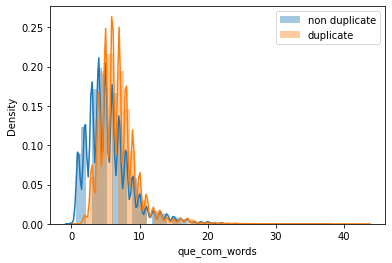

In [34]:
sns.distplot(total_data[total_data['is_duplicate'] == 0]['que_com_words'],label='non duplicate')
sns.distplot(total_data[total_data['is_duplicate'] == 1]['que_com_words'],label='duplicate')
plt.legend()
plt.show()

# Training the model

In [35]:
features = total_data.iloc[:, :-1].values
target = total_data.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

In [36]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
f"Accuracy: {accuracy_score(y_test,y_pred)}"

'Accuracy: 0.7991623174783777'

<AxesSubplot:>

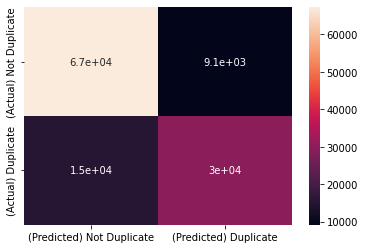

In [38]:
conf_mat = confusion_matrix(y_pred=y_pred, y_true=y_test)
sns.heatmap(
    conf_mat, 
    annot=True, 
    xticklabels=['(Predicted) Not Duplicate', '(Predicted) Duplicate'],
    yticklabels=['(Actual) Not Duplicate', '(Actual) Duplicate']
)